# K近邻法

## 一、基本概念

1．$k$近邻法是基本且简单的分类与回归方法。

$k$近邻法的基本做法是：对给定的训练实例点和输入实例点，首先确定输入实例点的$k$个最近邻训练实例点，然后利用这$k$个训练实例点的类的多数来预测输入实例点的类。

2．$k$近邻模型对应于基于训练数据集对特征空间的一个划分。$k$近邻法中，当训练集、距离度量、$k$值及分类决策规则确定后，其结果唯一确定。

3．$k$近邻法三要素：距离度量、$k$值的选择和分类决策规则。

- 常用的距离度量是欧氏距离及更一般的**$L_p$**距离。
- $k$值小时，$k$近邻模型更复杂；$k$值大时，$k$近邻模型更简单。
- $k$值的选择反映了对近似误差与估计误差之间的权衡，通常由交叉验证选择最优的$k$。

**常用的分类决策规则是多数表决，对应于经验风险最小化。**

4．$k$近邻法的实现需要考虑如何快速搜索k个最近邻点。

- **kd**树是一种便于对k维空间中的数据进行快速检索的数据结构。

- kd树是二叉树，表示对$k$维空间的一个划分，其每个结点对应于$k$维空间划分中的一个超矩形区域。

- 利用**kd**树可以省去对大部分数据点的搜索， 从而减少搜索的计算量。

## 二、距离度量

设特征空间$x$是$n$维实数向量空间 ，$x_{i}, x_{j} \in \mathcal{X}$,$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(n)}\right)^{\mathrm{T}}$,$x_{j}=\left(x_{j}^{(1)}, x_{j}^{(2)}, \cdots, x_{j}^{(n)}\right)^{\mathrm{T}}$
，则：$x_i$,$x_j$的$L_p$距离定义为:


$$
L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{i=1}^{n}\left|x_{i}^{(i)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}
$$

- $p= 1$  曼哈顿距离
- $p= 2$  欧氏距离
- $p= \infty$   切比雪夫距离

In [2]:
import math
from itertools import combinations

In [8]:
# math.pow(a,b): a是底数，b是指数

def L(x, y, p=2):
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1/p)
    else:
        return 0

In [20]:
# 例题-3.1

x1 = [1,1]
x2 = [5,1]
x3 = [4,4]

for i in range(1,5):
    r = {'1-{}'.format(c): L(x1, c, p=i) for c in [x2, x3]}
    print(r)
    print(min(zip(r.values(), r.keys())))  # zip([4,6],[1-[5,1], 1-[4,4]]) = [(4,1-[5,1]), (6,1-[4,4])]

{'1-[5, 1]': 4.0, '1-[4, 4]': 6.0}
(4.0, '1-[5, 1]')
{'1-[5, 1]': 4.0, '1-[4, 4]': 4.242640687119285}
(4.0, '1-[5, 1]')
{'1-[5, 1]': 3.9999999999999996, '1-[4, 4]': 3.7797631496846193}
(3.7797631496846193, '1-[4, 4]')
{'1-[5, 1]': 4.0, '1-[4, 4]': 3.5676213450081633}
(3.5676213450081633, '1-[4, 4]')


In [23]:
a = [1,2,3]
b = [4,5,6]
c = [4,5,6,7,8]
zipped = zip(a,c)  
list(zipped)

[(1, 4), (2, 5), (3, 6)]

## 三、算法实现

遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [9]:
# data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length','sepal width','petal length','petal width','label']

In [10]:
df.head()

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


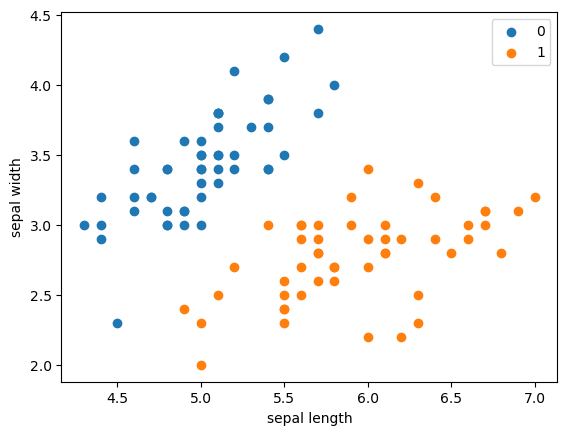

In [11]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [12]:
data = np.array(df.iloc[:100, [0,1,-1]])
X, y = data[:,:-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("There are {} train samples".format(y_train.shape[0]))
print("There are {} test samples".format(y_test.shape[0]))

There are 80 train samples
There are 20 test samples


In [13]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.X_train = X_train
        self.y_train = y_train
        self.n = n_neighbors
        self.p = p
        
    def predict(self, X):
        # 取出n个点
        knn_list = []
        for i in range(self.n):
            dist = np.linalg.norm(X - X_train[i], ord=self.p)  # 求L范数
            knn_list.append((dist, y_train[i]))
        
        for i in range(self.n, len(X_train)):
            """
            循环判断剩下的点和X的距离，如果距离比目前的最大值小，则替换最大值，再次排序，依次进行
            """
            max_index = knn_list.index(max(knn_list, key = lambda x:x[0]))
            dist = np.linalg.norm(X - X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        
        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        return max_count
    
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count/len(X_test)

In [14]:
test_point = [6.0 ,3.0]
clf = KNN(X_train, y_train)

print('Test Point: {}'.format(clf.predict(test_point)))
print('Score: {}'.format(clf.score(X_test, y_test)))

Test Point: 1.0
Score: 1.0


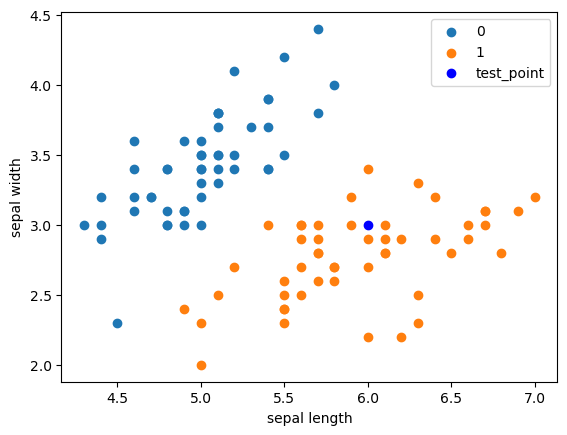

In [15]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

## scikit-learn实例

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
clf.score(X_test, y_test)

1.0

### sklearn.neighbors.KNeighborsClassifier

- n_neighbors: 临近点个数
- p: 距离度量
- algorithm: 近邻算法，可选{'auto', 'ball_tree', 'kd_tree', 'brute'}
- weights: 确定近邻的权重

## 四、构造kd树

### 基本概念

**kd**树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树形数据结构。

**kd**树是二叉树，表示对$k$维空间的一个划分（partition）。构造**kd**树相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，构成一系列的k维超矩形区域。kd树的每个结点对应于一个$k$维超矩形区域。

构造**kd**树的方法如下：

- 构造根结点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域；通过下面的递归方法，不断地对$k$维空间进行切分，生成子结点。在超矩形区域（结点）上选择一个坐标轴和在此坐标轴上的一个切分点，确定一个超平面，这个超平面通过选定的切分点并垂直于选定的坐标轴，将当前超矩形区域切分为左右两个子区域（子结点）；这时，实例被分到两个子区域。这个过程直到子区域内没有实例时终止（终止时的结点为叶结点）。在此过程中，将实例保存在相应的结点上。

- 通常，依次选择坐标轴对空间切分，选择训练实例点在选定坐标轴上的中位数（median）为切分点，这样得到的**kd**树是平衡的。注意，平衡的**kd**树搜索时的效率未必是最优的。


### 构造平衡kd树算法

输入：$k$维空间数据集$T＝\{x_1，x_2,…,x_N\}$，

其中$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(k)}\right)^{\mathrm{T}}$ ，$i＝1,2,…,N$；

输出：**kd**树。

（1）开始：构造根结点，根结点对应于包含$T$的$k$维空间的超矩形区域。

- 选择$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的中位数为切分点，将根结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

- 由根结点生成深度为1的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域， 右子结点对应于坐标$x^{(1)}$大于切分点的子区域。

- 将落在切分超平面上的实例点保存在根结点。

（2）重复：对深度为$j$的结点，选择$x^{(1)}$为切分的坐标轴，$l＝j(modk)+1$，以该结点的区域中所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

- 由该结点生成深度为$j+1$的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域，右子结点对应坐标$x^{(1)}$大于切分点的子区域。

- 将落在切分超平面上的实例点保存在该结点。

（3）直到两个子区域没有实例存在时停止。从而形成**kd**树的区域划分。